In [14]:
# Sentiment algorithm 2. Sequence of lemmas as single feature input and multi sentiment classification of sentence as output

# Model is saved in saved_models/model_name/model_variant.h5
# Run history is saved in logged_models/model_name sorted by model_variants and run-datetime
# Runs can be viewed using tensorboard: tensorboard --logdir=PATH --port=6006
# Example given: tensorboard --logdir=C:\BAC\Ezra\sentiment\models\logged_models\sent_algo_1 --port=6006
model_name = 'sent_algo_2'
model_variant = 'base'

training_size = 3000000
test_size = 1000000

In [15]:
# SETUP IMPORTS
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from keras import callbacks

%reload_ext autoreload
%autoreload 2
from helpers.sentiment_functions import gender_seq_to_single
from helpers.sentiment_functions import equal_genders
from helpers.sentiment_functions import encode_feature
from helpers.sentiment_functions import plot_sentence_lengths
from helpers.sentiment_functions import plot_confusion_matrix_multi
from helpers.sentiment_functions import get_metrics
from helpers.sentiment_functions import round_list
from helpers.sentiment_functions import encode_list
from helpers.sentiment_functions import one_hot_list
from helpers.sentiment_functions import xai_multi

pd.set_option('display.max_columns', 10, 'display.width', 10, 'display.max_colwidth', 20, 'display.max_rows',100)

In [16]:
# LOAD DATASET
df = pd.read_json('../datasets/sentiment_corpus.json')
print("Corpus sample size is:", len(df))

print(training_size, "samples are taken from the head for training")
print(test_size, "samples are taken from the tail for test")

# We take from the head for training data and tail for test data
# This is done since the last 25% of the corpus is not fitted on the polarity dict, thereby preventing overfitting
train_data = df.head(training_size)
test_data = df.tail(test_size)

train_data

Corpus sample size is: 4970467
3000000 samples are taken from the head for training
1000000 samples are taken from the tail for test


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,organizations,organization,NOUN,-0.223025,F
1,1,decided,decide,VERB,-0.039008,F
2,1,drop,drop,VERB,-0.058436,F
3,1,women,woman,NOUN,0.272143,F
4,1,accused,accuse,VERB,0.006282,F
...,...,...,...,...,...,...
2999995,404384,cool,cool,ADJ,0.037064,F
2999996,404384,factors,factor,NOUN,-0.055300,F
2999997,404384,like,like,ADP,-0.129606,F
2999998,404384,pore,pore,NOUN,0.000000,F


In [17]:
# GROUP-BY SENTENCE NUMBER 
train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))

train_data['Gender'] = gender_seq_to_single(train_data['Gender'])
test_data['Gender'] = gender_seq_to_single(test_data['Gender'])
train_data

C:\Users\hanse\AppData\Local\Temp/ipykernel_13132/3370681660.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
C:\Users\hanse\AppData\Local\Temp/ipykernel_13132/3370681660.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,"[organizations, ...","[organization, d...","[NOUN, VERB, VER...",[-0.223024829414...,F
1,2,"[Women, previous...","[woman, previous...","[NOUN, ADV, VERB...",[0.2721428399909...,F
2,3,"[response, alleg...","[response, alleg...","[NOUN, NOUN, PRO...",[-0.028053754978...,F
3,4,"[aware, allegati...","[aware, allegati...","[ADJ, NOUN, PROPN]",[-0.015715441394...,F
4,5,"[point, Visa, su...","[point, Visa, su...","[NOUN, PROPN, VE...",[-0.228729956550...,F
...,...,...,...,...,...,...
362024,404378,"[Philosophy, Hel...","[philosophy, hel...","[NOUN, VERB, NOUN]","[0.0, -0.2512493...",F
362025,404379,"[Philosophy, gem...","[Philosophy, gem...","[PROPN, NOUN, AD...","[0.0, 0.0, -0.19...",F
362026,404381,"[Benefit, POREfe...","[benefit, porefe...","[VERB, NOUN, NOU...",[-0.167289610994...,F
362027,404383,[Pores],[Pores],[PROPN],[0.0],F


In [18]:
# SHUFFLE TRAINING AND TEST DATA
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)
train_data

,Sentence #,Word,Lemma,POS,Polarity,Gender
0,68391,"[simply, don, pe...","[simply, don, pe...","[ADV, AUX, NOUN,...",[-0.050431085162...,F
1,121458,"[new, report, bu...","[new, report, bu...","[ADJ, NOUN, NOUN...",[-0.291567575701...,M
2,341585,"[grew, house, th...","[grow, house, th...","[VERB, NOUN, PRO...",[-0.147545971375...,M
3,135184,"[Watch, video]","[watch, video]","[VERB, NOUN]",[-0.052758276030...,F
4,208911,"[ve, learned, ac...","[ve, learn, achi...","[AUX, VERB, VERB...","[0.0, -0.1552409...",M
...,...,...,...,...,...,...
362024,315082,"[Amidst, unrelen...","[amidst, unrelen...","[ADP, ADJ, NOUN,...","[0.0, 0.0, 0.0, ...",M
362025,86544,"[know, think, ad...","[know, think, ad...","[VERB, VERB, NOU...",[-0.154079530929...,F
362026,127288,"[went, detail, c...","[go, detail, com...","[VERB, VERB, NOU...",[-0.180665133529...,M
362027,53026,"[Feminism, encom...","[feminism, encom...","[NOUN, VERB, ADJ...",[0.0561953485051...,F


<AxesSubplot:>

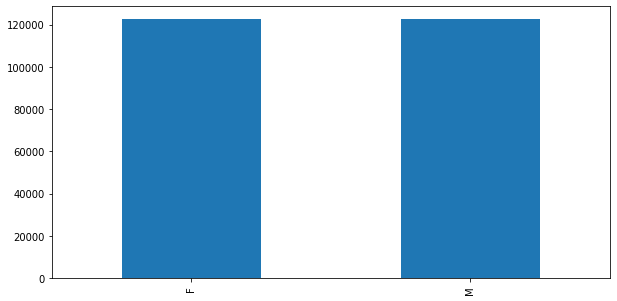

In [19]:
# EQUAL GENDER SAMPLES TO PREVENT BIAS
train_data = equal_genders(train_data)
test_data = equal_genders(test_data)

train_data["Gender"].value_counts().plot(kind="bar", figsize=(10,5))

No handles with labels found to put in legend.


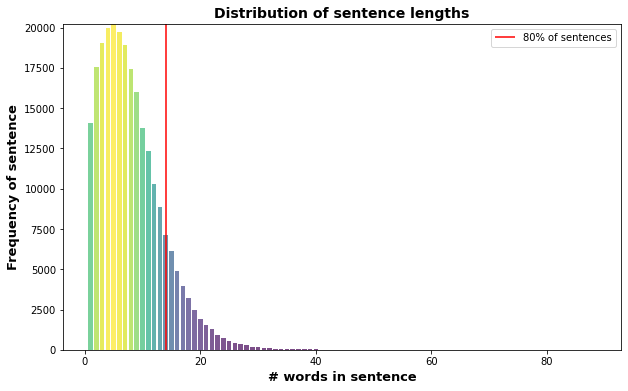

Decision boundary / 80 pct of sentence lengths is: 14


In [20]:
# VISUALIZE SENTENCE LENGTHS AND DECISION BOUNDARY
decision_boundary = plot_sentence_lengths(train_data)
print("Decision boundary / 80 pct of sentence lengths is:", decision_boundary)

In [21]:
# ONE-HOT TARGET (GENDER)
classes = [-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
n_unique_classes = len(classes) + 1 # +1 for padding

pol_to_enc = {
    -1.0: 1,
    -0.9: 2,
    -0.8: 3,
    -0.7: 4,
    -0.6: 5,
    -0.5: 6,
    -0.4: 7,
    -0.3: 8,
    -0.2: 9,
    -0.1: 10,
    0.0: 11,
    0.1: 12,
    0.2: 13,
    0.3: 14,
    0.4: 15,
    0.5: 16,
    0.6: 17,
    0.7: 18,
    0.8: 19,
    0.9: 20,
    1.0: 21
}

train_pols_rounded = round_list(train_data['Polarity'])
train_pols_encoded = encode_list(train_pols_rounded, pol_to_enc)
y_train = one_hot_list(train_pols_encoded, n_unique_classes)

test_pols_rounded = round_list(test_data['Polarity'])
test_pols_encoded = encode_list(test_pols_rounded, pol_to_enc)
y_test = one_hot_list(test_pols_encoded, n_unique_classes)


print("Unique polarities:", [classes])
print("Unique polarities:", encode_list([classes], pol_to_enc))

print("\nTraining data example polarity sequence:", train_data['Polarity'][:1].tolist())
print("Training data example polarity sequence rounded:", train_pols_rounded[0])
print("Training data example polarity sequence encoded:", train_pols_encoded[0])
print("Training data example polarity sequence one-hot:", y_train[0])

print("\nTest data example polarity sequence:", test_data['Polarity'][:1].tolist())
print("Test data example polarity sequence rounded:", test_pols_rounded[0])
print("Test data example polarity sequence encoded:", test_pols_encoded[0])
print("Test data example polarity sequence one-hot:", y_test[0])

Unique polarities: [[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]]
Unique polarities: [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]]

Training data example polarity sequence: [[-0.050431085162603, 0.0, 0.0, 0.0, -0.034602791301544006, 0.019725594599676002]]
Training data example polarity sequence rounded: [-0.1, 0.0, 0.0, 0.0, -0.0, 0.0]
Training data example polarity sequence encoded: [10, 11, 11, 11, 11, 11]
Training data example polarity sequence one-hot: [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
   

In [22]:
# ENCODE FEATURES TO INTEGERS, EQUAL LENGTHS AND PAD
# Inspired by: https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
train_data['Lemma_enc'], test_data['Lemma_enc'], vocab_size = encode_feature(train_data['Lemma'], test_data['Lemma'])

trunc_type = 'post'
padding_type = 'post'
max_len = decision_boundary

X_train = pad_sequences(train_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)
X_test = pad_sequences(test_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)

y_train = pad_sequences(y_train, dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)
y_test = pad_sequences(y_test, dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)

In [23]:
# LOADING MODEL
from tensorflow import keras
model = keras.models.load_model('saved_models/sent_algo_2/base_v2.h5')

In [24]:
# PREDICT TEST DATA
y_pred = model.predict(X_test)
cm_pred = y_pred.argmax(axis=-1).flatten()
cm_true = y_test.argmax(axis=-1).flatten()

In [25]:
count = 0
for seq in test_data['Polarity'].to_numpy():
    count += len(seq)
count
print("test_data polarities length", count)
print("cm_pred shape", cm_pred.shape)
print("cm_true shape", cm_true.shape)
print("MEANING", cm_pred.shape[0]-count, "polarities are paddings")
print(cm_pred[:50])
print(cm_true[:50])

test_data polarities length 878567
cm_pred shape (1449812,)
cm_true shape (1449812,)
MEANING 571245 polarities are paddings
[ 9 11  9 11 10  9 12 10 10 11 11 12 11 11 10 12  8 12  8  8 11 10 11 11
 11 11 11 11 11 11 11  9  9 11  7 11 11 11 11 11 11 11 10 10 10 11 11 11
 11 11]
[10 11  9 11 11  8  8  8  9 10 11  8  9  8 10 10 11 12  9 10 11 10  0  0
  0  0  0  0 11  8 11  9  9 11  7 11  0  0  0  0  0  0 11 11 11 11 11 11
 10 11]


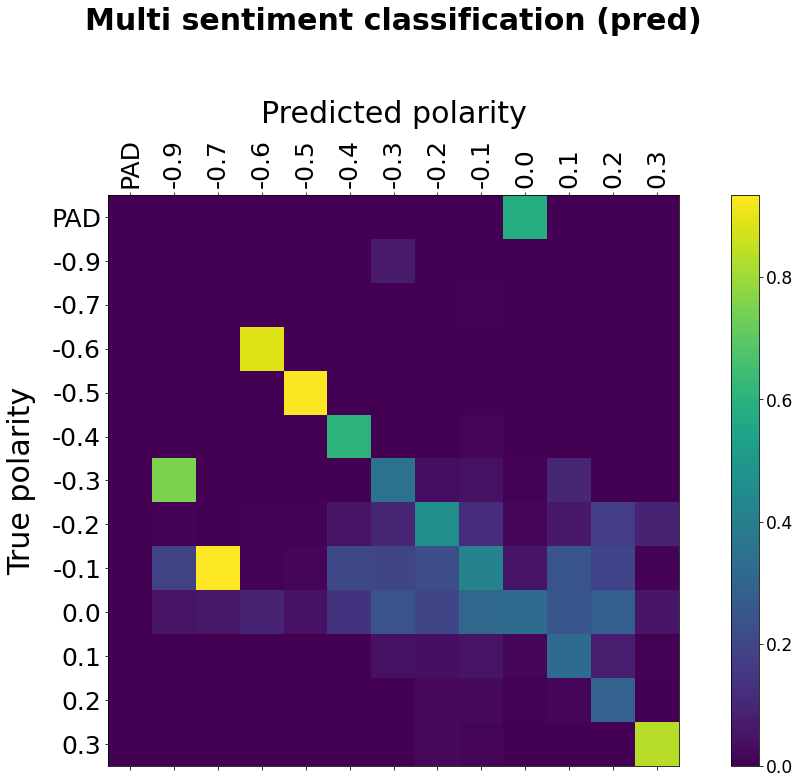

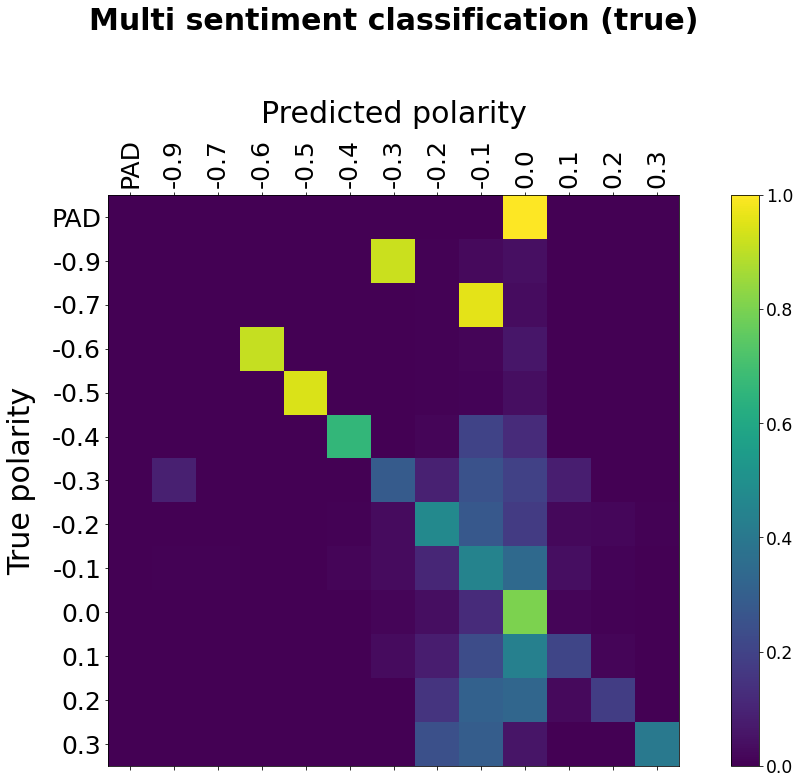

In [26]:
# PLOTTING CONFUSION MATRIX
enc_to_pol = {
  0: "PAD",
  1 : -1.0,
  2 : -0.9,
  3 : -0.8,
  4 : -0.7,
  5 : -0.6,
  6 : -0.5,
  7 : -0.4,
  8 : -0.3,
  9 : -0.2,
  10 : -0.1,
  11 : 0.0,
  12 : 0.1,
  13 : 0.2,
  14 : 0.3,
  15 : 0.4,
  16 : 0.5,
  17 : 0.6,
  18 : 0.7,
  19 : 0.8,
  20 : 0.9,
  21 : 1.0,
}

plot_confusion_matrix_multi(cm_true, cm_pred, 'Multi sentiment classification', 'Predicted polarity', 'True polarity', enc_to_pol)

In [27]:
# PRINTING METRICS
present_polarities = []

for x in np.unique(np.array(np.concatenate((cm_true,cm_pred)))):
    present_polarities.append(enc_to_pol[x])

get_metrics(cm_true, cm_pred, present_polarities, 'Polarity')

C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: Unde

,Polarity,precision,recall,f1-score,support
0,PAD,0.00,0.00,0.00,637917.0
1,-0.9,0.00,0.00,0.00,1804.0
2,-0.7,0.00,0.00,0.00,984.0
3,-0.6,0.89,0.91,0.90,6290.0
4,-0.5,0.93,0.94,0.94,2888.0
5,-0.4,0.60,0.66,0.63,11008.0
6,-0.3,0.35,0.29,0.32,30695.0
7,-0.2,0.46,0.47,0.47,80768.0
8,-0.1,0.42,0.45,0.43,166939.0
9,0.0,0.33,0.80,0.47,450184.0


In [29]:
# USE XAI ON PREDICTIONS
xai_multi(y_pred.argmax(axis=-1)[:500], test_data, 2, enc_to_pol)


---------------------------------------------------------------------------------------
The sentence: "Below are several tactics to help you maintain a high level of motivation throughout your job search: 1.".

Was predicted to be masculine (-0.3).

Most masculine words in sentence are:

'job' with a polarity of -0.4
'high' with a polarity of -0.2

---------------------------------------------------------------------------------------
The sentence: "The $700 million bump up came from an increase in price and a decrease in the number of overdrafts.".

Was predicted to be masculine (-0.2).

Most masculine words in sentence are:

'came' with a polarity of -0.2
'number' with a polarity of -0.2

---------------------------------------------------------------------------------------
The sentence: "What do I mean?".

Was predicted to be masculine (-0.3).

Most masculine words in sentence are:

'mean' with a polarity of -0.3

-------------------------------------------------------------------